📦 **Prerequisites**

In [1]:
pip install tensorflow==2.10 datasets pandas scikit-learn pillow opencv-python tqdm matplotlib "numpy<2.0,>=1.23.5" tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 2: GPU Check
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    print("✅ SUCCESS! TensorFlow is now configured to check for the GPU.")
    print("GPU devices recognized by TensorFlow:", gpus)
else:
    print("❌ ERROR: No GPU devices were found by TensorFlow.")

Num GPUs Available:  1
✅ SUCCESS! TensorFlow is now configured to check for the GPU.
GPU devices recognized by TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Setup, Load, and Initial Inspection**

In [3]:
import os
import shutil
import random
import cv2
import numpy as np
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
from PIL import Image
from sklearn.utils import resample
import matplotlib.pyplot as plt

# --- Configuration ---
DATASET_NAME = "marmal88/skin_cancer"
RAW_TRAIN_DIR = "./raw_dataset_input" # Temporary directory for raw train data
BASE_OUTPUT_DIR = "./skin_cancer_dataset_final" # Root for final structure
PROCESSED_TRAIN_DIR = os.path.join(BASE_OUTPUT_DIR, "train") # Final train location
UNDERSAMPLE_TARGET = 3200 
TARGET_AUGMENTATION_FACTOR = 4 
IMAGE_SIZE = (224, 224)
DENOISING_H = 10 

# Create necessary directories
os.makedirs(RAW_TRAIN_DIR, exist_ok=True)
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
os.makedirs(PROCESSED_TRAIN_DIR, exist_ok=True)

print("### ⬇️ 1. Loading and Saving Raw Train Split")
print(f"Loading dataset: {DATASET_NAME}...")

# Load the 'train' split
dataset = load_dataset(DATASET_NAME, split="train")

# --- CORRECTED LABEL FEATURE NAME ---
LABEL_FEATURE_NAME = "dx"
all_labels = dataset.unique(LABEL_FEATURE_NAME)
label_names = all_labels 
print(f"✅ Successfully identified label feature as: '{LABEL_FEATURE_NAME}'")
# ------------------------------------

# Store initial file paths and counts
raw_data_paths_by_class = {}
class_counts = {name: 0 for name in label_names}

def save_image_local(example, root_dir, class_counts):
    """Saves image to local class folder and updates counts."""
    label_name = example[LABEL_FEATURE_NAME]
    class_dir = os.path.join(root_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)
    
    filename = f"{example['image_id']}.jpg"
    filepath = os.path.join(class_dir, filename)
    
    example['image'].save(filepath)
    class_counts[label_name] += 1
    
    if label_name not in raw_data_paths_by_class:
        raw_data_paths_by_class[label_name] = []
    raw_data_paths_by_class[label_name].append(filepath)

# Apply the save function to all examples
for example in tqdm(dataset, desc="Saving Raw Train Images"):
    save_image_local(example, RAW_TRAIN_DIR, class_counts)

# Display initial counts
print("\n### 📊 2. Initial Raw Train Dataset Class Distribution")
df_initial = pd.DataFrame(class_counts.items(), columns=['Class Name', 'Raw Image Count'])

# Strategy description MUST use the correct class name: 'melanocytic_Nevi'
df_initial['Strategy'] = df_initial['Class Name'].apply(
    lambda x: f'Undersample and Denoise to ~{UNDERSAMPLE_TARGET}' if x == 'melanocytic_Nevi' else f'Augment x{TARGET_AUGMENTATION_FACTOR} and Denoise'
)
df_initial = df_initial.sort_values(by='Raw Image Count', ascending=False).reset_index(drop=True)

print(df_initial.to_markdown(index=False))

f:\Program Files\CSE445_Project\CSE445_Project_CustomCNN\alindo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ⬇️ 1. Loading and Saving Raw Train Split
Loading dataset: marmal88/skin_cancer...
✅ Successfully identified label feature as: 'dx'


Saving Raw Train Images: 100%|██████████| 9577/9577 [00:45<00:00, 209.32it/s]



### 📊 2. Initial Raw Train Dataset Class Distribution
| Class Name                    |   Raw Image Count | Strategy                         |
|:------------------------------|------------------:|:---------------------------------|
| melanocytic_Nevi              |              6405 | Undersample and Denoise to ~3200 |
| melanoma                      |              1076 | Augment x4 and Denoise           |
| benign_keratosis-like_lesions |              1048 | Augment x4 and Denoise           |
| basal_cell_carcinoma          |               487 | Augment x4 and Denoise           |
| actinic_keratoses             |               315 | Augment x4 and Denoise           |
| vascular_lesions              |               136 | Augment x4 and Denoise           |
| dermatofibroma                |               110 | Augment x4 and Denoise           |


**Download Validation and Test Splits**

In [4]:
# --- Configuration for Splits ---
SPLITS_TO_DOWNLOAD = ["validation", "test"]

print("\n### ⬇️ 3. Downloading and Structuring Validation and Test Splits")

def save_split_local(split_name):
    """Downloads and saves a dataset split without modification."""
    split_dataset = load_dataset(DATASET_NAME, split=split_name)
    
    # Final location: BASE_OUTPUT_DIR/split_name
    split_output_dir = os.path.join(BASE_OUTPUT_DIR, split_name)
    os.makedirs(split_output_dir, exist_ok=True)
    
    print(f"Saving original {split_name} images to {split_output_dir}...")
    
    split_image_count = 0
    for example in tqdm(split_dataset, desc=f"Saving {split_name} Images"):
        label_name = example[LABEL_FEATURE_NAME]
        
        class_dir = os.path.join(split_output_dir, label_name)
        os.makedirs(class_dir, exist_ok=True)
        
        filename = f"{example['image_id']}.jpg"
        filepath = os.path.join(class_dir, filename)
        example['image'].save(filepath)
        split_image_count += 1
        
    print(f"✅ {split_name} split saved successfully. Total images: {split_image_count}")
    return split_image_count

total_val_test_images = 0
for split in SPLITS_TO_DOWNLOAD:
    total_val_test_images += save_split_local(split)

print(f"\nTotal Validation and Test images saved: {total_val_test_images}")


### ⬇️ 3. Downloading and Structuring Validation and Test Splits
Saving original validation images to ./skin_cancer_dataset_final\validation...


Saving validation Images: 100%|██████████| 2492/2492 [00:11<00:00, 211.32it/s]


✅ validation split saved successfully. Total images: 2492
Saving original test images to ./skin_cancer_dataset_final\test...


Saving test Images: 100%|██████████| 1285/1285 [00:06<00:00, 213.10it/s]

✅ test split saved successfully. Total images: 1285

Total Validation and Test images saved: 3777


**Balancing, Augmentation, and Denoising Logic**

In [ ]:
import cv2
import numpy as np
import random
import os
import shutil
from tqdm import tqdm
from sklearn.utils import resample


DENOISING_H = 10 
IMAGE_SIZE = (224, 224)
BASE_OUTPUT_DIR = "./skin_cancer_dataset_final"
PROCESSED_TRAIN_DIR = os.path.join(BASE_OUTPUT_DIR, "train")


raw_counts_data = {
    'melanocytic_Nevi': 6405, 'melanoma': 1076, 'benign_keratosis-like_lesions': 1048,
    'basal_cell_carcinoma': 487, 'actinic_keratoses': 315,
    'vascular_lesions': 136, 'dermatofibroma': 110
}



def preprocess_and_denoise(image_np_rgb):
    """Applies Denoising, Resizing, and converts to BGR for saving."""
    denoised_img = cv2.fastNlMeansDenoisingColored(image_np_rgb, None, DENOISING_H, DENOISING_H, 7, 21)
    resized_img = cv2.resize(denoised_img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)

# --- 10 AUGMENTATION METHODS (0-9) ---
def augment_image(image_np, aug_type):
    """Applies one of the ten specified augmentations (0-9). Image_np must be RGB."""
    if aug_type == 0: # Rotation
        k = random.choice([0, 1, 2]); return cv2.rotate(image_np, k)
    elif aug_type == 1: # Horizontal Flip
        return cv2.flip(image_np, 1)
    elif aug_type == 2: # Vertical Flip
        return cv2.flip(image_np, 0)
    elif aug_type == 3: # Cropping / Random Resizing (Zoom)
        h, w = image_np.shape[:2]; scale = random.uniform(0.8, 0.95); new_h, new_w = int(h * scale), int(w * scale)
        start_x = random.randint(0, w - new_w); start_y = random.randint(0, h - new_h)
        cropped_img = image_np[start_y:start_y + new_h, start_x:start_x + new_w]
        return cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)
    elif aug_type == 4: # Brightness / Contrast Adjustments
        alpha = random.uniform(0.8, 1.2); beta = random.randint(-15, 15)
        return cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
    elif aug_type == 5: # Color Jitter
        hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV); h_shift = random.randint(-10, 10); s_shift = random.randint(-30, 30); v_shift = random.randint(-30, 30)
        hsv[..., 0] = np.clip(hsv[..., 0] + h_shift, 0, 179); hsv[..., 1] = np.clip(hsv[..., 1] + s_shift, 0, 255); hsv[..., 2] = np.clip(hsv[..., 2] + v_shift, 0, 255)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    elif aug_type == 6: # Gaussian Blur
        ksize = random.choice([3, 5])
        return cv2.GaussianBlur(image_np, (ksize, ksize), 0)
    elif aug_type == 7: # Translation/Shift
        h, w = image_np.shape[:2]
        tx = random.randint(-w // 10, w // 10)
        ty = random.randint(-h // 10, h // 10)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image_np, M, (w, h), borderMode=cv2.BORDER_WRAP)
    elif aug_type == 8: # Mild Shearing
        h, w = image_np.shape[:2]
        shear_factor = random.uniform(-0.1, 0.1)
        pts1 = np.float32([[0, 0], [w, 0], [0, h]])
        pts2 = np.float32([[0, 0], [w, 0], [shear_factor * w, h]]) 
        M = cv2.getAffineTransform(pts1, pts2)
        return cv2.warpAffine(image_np, M, (w, h))
    elif aug_type == 9: # Salt-and-Pepper Noise
        h, w, c = image_np.shape
        noisy_img = np.copy(image_np)
        num_salt = np.ceil(0.0005 * image_np.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_np.shape]
        noisy_img[coords[0], coords[1], :] = 255
        num_pepper = np.ceil(0.0005 * image_np.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_np.shape]
        noisy_img[coords[0], coords[1], :] = 0
        return noisy_img
    return image_np


print("\n### 🛠️ 4. Balancing, Augmentation, and Denoising Execution (FIXED FACTOR STRATEGY)")

# --- FIXED FACTOR BALANCING CONFIGURATION ---
UNDERSAMPLE_TARGET = 4000
FIXED_FACTORS = {
    'benign_keratosis-like_lesions': 4,
    'melanoma': 4,
    'vascular_lesions': 4,
    'dermatofibroma': 4,
    'basal_cell_carcinoma': 7,
    'actinic_keratoses': 10
}
# -------------------------------------------

final_counts = {name: 0 for name in raw_counts_data.keys()}
total_images_saved = 0

# --- Clean up previous processed data before starting ---
if os.path.exists(PROCESSED_TRAIN_DIR):
    shutil.rmtree(PROCESSED_TRAIN_DIR)
os.makedirs(PROCESSED_TRAIN_DIR, exist_ok=True)

# Process each class
for class_name, paths in tqdm(raw_data_paths_by_class.items(), desc="Processing Classes"):
    
    class_out_dir = os.path.join(PROCESSED_TRAIN_DIR, class_name)
    os.makedirs(class_out_dir, exist_ok=True)
    
    current_paths = paths
    
    # 1. Undersampling for melanocytic_Nevi
    if class_name == 'melanocytic_Nevi': 
        n_samples = min(len(paths), UNDERSAMPLE_TARGET) 
        current_paths = resample(paths, n_samples=n_samples, replace=False, random_state=42)
        print(f"  - {class_name}: Undersampled from {len(paths)} to {len(current_paths)}.")
        
        for path in current_paths:
            img = cv2.imread(path); 
            if img is None: continue
            processed_img = preprocess_and_denoise(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            base_filename = os.path.basename(path).replace(".jpg", "")
            output_path = os.path.join(class_out_dir, f"{base_filename}_0_orig_denoised.jpg")
            cv2.imwrite(output_path, processed_img)
            total_images_saved += 1; final_counts[class_name] += 1
            
    # 2. Fixed Factor Augmentation for all other classes
    else:
        
        total_copies_needed = FIXED_FACTORS.get(class_name, 1) 
        
        
        raw_count = raw_counts_data.get(class_name, len(current_paths))
        print(f"  - {class_name}: Augmentation Factor: x{total_copies_needed} (Raw: {raw_count}).")

        
        for path in current_paths:
            img = cv2.imread(path); 
            if img is None: continue
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            base_filename = os.path.basename(path).replace(".jpg", "")
            
            # A. Save Original (Denoised and Preprocessed) - This counts as copy #1
            processed_orig = preprocess_and_denoise(img_rgb)
            cv2.imwrite(os.path.join(class_out_dir, f"{base_filename}_0_orig_denoised.jpg"), processed_orig)
            total_images_saved += 1; final_counts[class_name] += 1
            
            # B. Save Augmented Copies (Run the loop total_copies_needed - 1 times)
            num_augmentations = total_copies_needed - 1
            aug_types = list(range(10)) 
            
            for j in range(num_augmentations): 
                # Cycle through the 10 available augmentation types for variety
                aug_type = aug_types[j % len(aug_types)] 
                
                augmented_img = augment_image(img_rgb, aug_type)
                processed_aug = preprocess_and_denoise(augmented_img)
                
                output_path = os.path.join(class_out_dir, f"{base_filename}_{j+1}_aug{aug_type}_denoised.jpg")
                cv2.imwrite(output_path, processed_aug)
                total_images_saved += 1; final_counts[class_name] += 1

print(f"\n✅ Processing complete. Total images saved to '{PROCESSED_TRAIN_DIR}': {total_images_saved}")


### 🛠️ 4. Balancing, Augmentation, and Denoising Execution (FIXED FACTOR STRATEGY)


Processing Classes:   0%|          | 0/7 [00:00<?, ?it/s]

  - actinic_keratoses: Augmentation Factor: x10 (Raw: 315).


Processing Classes:  14%|█▍        | 1/7 [37:39<3:45:59, 2259.87s/it]

  - basal_cell_carcinoma: Augmentation Factor: x7 (Raw: 487).


Processing Classes:  29%|██▊       | 2/7 [1:18:19<3:17:08, 2365.78s/it]

  - benign_keratosis-like_lesions: Augmentation Factor: x4 (Raw: 1048).


Processing Classes:  43%|████▎     | 3/7 [2:08:25<2:57:12, 2658.03s/it]

  - dermatofibroma: Augmentation Factor: x4 (Raw: 110).


Processing Classes:  57%|█████▋    | 4/7 [2:13:41<1:26:39, 1733.24s/it]

  - melanocytic_Nevi: Undersampled from 6405 to 4000.


Processing Classes:  71%|███████▏  | 5/7 [3:01:38<1:11:31, 2146.00s/it]

  - melanoma: Augmentation Factor: x4 (Raw: 1076).


Processing Classes:  86%|████████▌ | 6/7 [3:53:04<41:05, 2465.42s/it]  

  - vascular_lesions: Augmentation Factor: x4 (Raw: 136).


Processing Classes: 100%|██████████| 7/7 [3:59:34<00:00, 2053.49s/it]


✅ Processing complete. Total images saved to './skin_cancer_dataset_final\train': 20039


**Final Verification and Histogram**


### 5. Final Balanced Dataset Class Distribution (Train Split)
| Class Name                    |   Final Image Count | Factor (Approx)   |
|:------------------------------|--------------------:|:------------------|
| melanoma                      |                4304 | x4.0              |
| benign_keratosis-like_lesions |                4192 | x4.0              |
| melanocytic_Nevi              |                4000 | x0.6              |
| basal_cell_carcinoma          |                3409 | x7.0              |
| actinic_keratoses             |                3150 | x10.0             |
| vascular_lesions              |                 544 | x4.0              |
| dermatofibroma                |                 440 | x4.0              |

Total Images in Final Balanced Train Dataset: **20039**
Total Images across all splits (Train + Val + Test): **23816**

### 6. Histogram of Updated Train Split Distribution


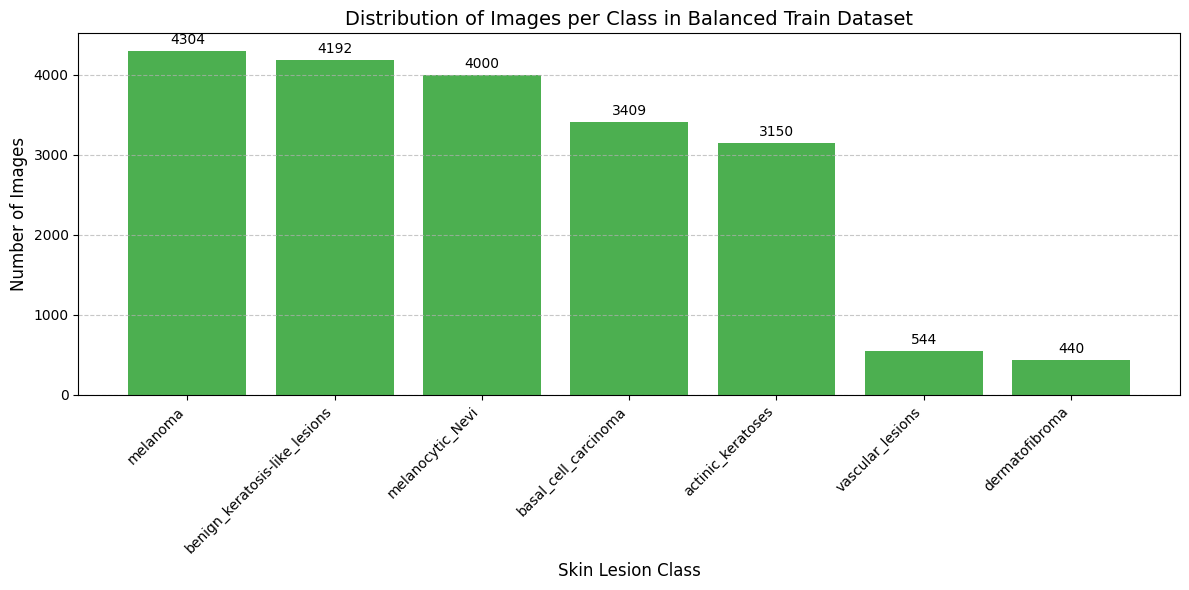


✅ Cleaned up temporary raw train directory: ./raw_dataset_input

### 7. Final Directory Structure Confirmation
The final dataset is structured under: **./skin_cancer_dataset_final**
- **./skin_cancer_dataset_final\train/**: Contains the BALANCED, AUGMENTED, and DENOISED images.
- **./skin_cancer_dataset_final\validation/**: Contains the ORIGINAL, UNTOUCHED images.
- **./skin_cancer_dataset_final\test/**: Contains the ORIGINAL, UNTOUCHED images.


In [ ]:

print("\n### 5. Final Balanced Dataset Class Distribution (Train Split)")

df_final = pd.DataFrame(final_counts.items(), columns=['Class Name', 'Final Image Count'])
df_final = df_final.sort_values(by='Final Image Count', ascending=False).reset_index(drop=True)


raw_counts_series = df_initial.set_index('Class Name')['Raw Image Count']
df_final['Factor (Approx)'] = df_final.apply(
    lambda row: f"x{round(row['Final Image Count'] / raw_counts_series[row['Class Name']], 1)}" 
        if raw_counts_series[row['Class Name']] > 0 else 'N/A', 
    axis=1
)


print(df_final.to_markdown(index=False))
total_final = df_final['Final Image Count'].sum()
print(f"\nTotal Images in Final Balanced Train Dataset: **{total_final}**")

print(f"Total Images across all splits (Train + Val + Test): **{total_final + total_val_test_images}**")

print("\n### 6. Histogram of Updated Train Split Distribution")


plt.figure(figsize=(12, 6))
bars = plt.bar(df_final['Class Name'], df_final['Final Image Count'], color='#4CAF50')


plt.title('Distribution of Images per Class in Balanced Train Dataset', fontsize=14)
plt.xlabel('Skin Lesion Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show() 


if os.path.exists(RAW_TRAIN_DIR):
    shutil.rmtree(RAW_TRAIN_DIR)
    print(f"\n✅ Cleaned up temporary raw train directory: {RAW_TRAIN_DIR}")

print("\n### 7. Final Directory Structure Confirmation")
print(f"The final dataset is structured under: **{BASE_OUTPUT_DIR}**")

print(f"- **{os.path.join(BASE_OUTPUT_DIR, 'train')}/**: Contains the BALANCED, AUGMENTED, and DENOISED images.")
print(f"- **{os.path.join(BASE_OUTPUT_DIR, 'validation')}/**: Contains the ORIGINAL, UNTOUCHED images.")
print(f"- **{os.path.join(BASE_OUTPUT_DIR, 'test')}/**: Contains the ORIGINAL, UNTOUCHED images.")

**Zipping the Final Dataset**

In [ ]:
import shutil

OUTPUT_ZIP_FILE = "skin_cancer_dataset_final_complete"
TARGET_DIR_TO_ZIP = BASE_OUTPUT_DIR

print(f"\n### 8. Zipping the Complete Dataset")
print(f"Creating zip archive at '{OUTPUT_ZIP_FILE}.zip'...")


try:
    shutil.make_archive(OUTPUT_ZIP_FILE, 'zip', root_dir=TARGET_DIR_TO_ZIP)
    print(f"✅ Final dataset successfully saved as **{OUTPUT_ZIP_FILE}.zip**")
except Exception as e:
    print(f"❌ Error during zipping: {e}")


### 8. Zipping the Complete Dataset
Creating zip archive at 'skin_cancer_dataset_final_complete.zip'...
✅ Final dataset successfully saved as **skin_cancer_dataset_final_complete.zip**
